(Chapter 5: Markov Decision Processes)=
```{raw} jupyter
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```
# Chapter 5: Markov Decision Processes


```{contents} Contents
:depth: 2
```

In [1]:
using Pkg;
Pkg.activate("./");

using PyCall;
pygui(:tk);

  Activating project at `D:\GitHub\book-dp1-test\code-book`


#### inventory_dp.jl

In [2]:
include("s_approx.jl")
using Distributions
m(x) = max(x, 0)  # Convenience function

function create_inventory_model(; β=0.98,     # discount factor
                                  K=40,       # maximum inventory
                                  c=0.2, κ=2, # cost paramters
                                  p=0.6)      # demand parameter
    ϕ(d) = (1 - p)^d * p        # demand pdf
    x_vals = collect(0:K)       # set of inventory levels
    return (; β, K, c, κ, p, ϕ, x_vals)
end

"The function B(x, a, v) = r(x, a) + β Σ_x′ v(x′) P(x, a, x′)."
function B(x, a, v, model; d_max=100)
    (; β, K, c, κ, p, ϕ, x_vals) = model
    revenue = sum(min(x, d) * ϕ(d) for d in 0:d_max) 
    current_profit = revenue - c * a - κ * (a > 0)
    next_value = sum(v[m(x - d) + a + 1] * ϕ(d) for d in 0:d_max)
    return current_profit + β * next_value
end

"The Bellman operator."
function T(v, model)
    (; β, K, c, κ, p, ϕ, x_vals) = model
    new_v = similar(v)
    for (x_idx, x) in enumerate(x_vals)
        Γx = 0:(K - x) 
        new_v[x_idx], _ = findmax(B(x, a, v, model) for a in Γx)
    end
    return new_v
end

"Get a v-greedy policy.  Returns a zero-based array."
function get_greedy(v, model)
    (; β, K, c, κ, p, ϕ, x_vals) = model
    σ_star = zero(x_vals)
    for (x_idx, x) in enumerate(x_vals)
        Γx = 0:(K - x) 
        _, a_idx = findmax(B(x, a, v, model) for a in Γx)
        σ_star[x_idx] = Γx[a_idx]
    end
    return σ_star
end

"Use successive_approx to get v_star and then compute greedy."
function solve_inventory_model(v_init, model)
    (; β, K, c, κ, p, ϕ, x_vals) = model
    v_star = successive_approx(v -> T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star
end

# == Plots == # 

using PyPlot
using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering

# Create an instance of the model and solve it
model = create_inventory_model()
(; β, K, c, κ, p, ϕ, x_vals) = model
v_init = zeros(length(x_vals))
v_star, σ_star = solve_inventory_model(v_init, model)

"Simulate given the optimal policy."
function sim_inventories(ts_length=400, X_init=0)
    G = Geometric(p)
    X = zeros(Int32, ts_length)
    X[1] = X_init
    for t in 1:(ts_length-1)
        D = rand(G)
        X[t+1] = m(X[t] - D) + σ_star[X[t] + 1]
    end
    return X
end


function plot_vstar_and_opt_policy(; fontsize=16, 
                   figname="figures/inventory_dp_vs.pdf",
                   savefig=false)
    fig, axes = plt.subplots(2, 1, figsize=(8, 6.5))

    ax = axes[1]
    ax.plot(0:K, v_star, label=L"v^*")
    ax.set_ylabel("value", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)

    ax = axes[2]
    ax.plot(0:K, σ_star, label=L"\sigma^*")
    ax.set_xlabel("inventory", fontsize=fontsize)
    ax.set_ylabel("optimal choice", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)
    if savefig == true
        fig.savefig(figname)
    end
end

function plot_ts(; fontsize=16, 
                   figname="figures/inventory_dp_ts.pdf",
                   savefig=false)
    X = sim_inventories()
    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.plot(X, label=L"X_t", alpha=0.7)
    ax.set_xlabel(L"t", fontsize=fontsize)
    ax.set_ylabel("inventory", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_ylim(0, maximum(X)+4)
    if savefig == true
        fig.savefig(figname)
    end
end


Completed iteration 25 with error 0.41042666932980687.
Completed iteration 50 with error 0.21020630773590554.
Completed iteration 75 with error 0.0955793466139987.


Completed iteration 100 with error 0.057146989183511465.
Completed iteration 125 with error 0.03436202542500766.
Completed iteration 150 with error 0.020703850094779597.


Completed iteration 175 with error 0.012485135075589682.
Completed iteration 200 with error 0.007532190047619736.
Completed iteration 225 with error 0.004544855368770584.


Completed iteration 250 with error 0.0027425060040116023.
Completed iteration 275 with error 0.0016549687240292599.
Completed iteration 300 with error 0.0009987055387483679.


Completed iteration 325 with error 0.0006026809169377145.
Completed iteration 350 with error 0.0003636960443387238.
Completed iteration 375 with error 0.00021947756642148875.


Completed iteration 400 with error 0.00013244692466685137.
Completed iteration 425 with error 7.992703666204193e-5.
Completed iteration 450 with error 4.823314469604156e-5.


Completed iteration 475 with error 2.9107000830919105e-5.
Completed iteration 500 with error 1.7565048199941202e-5.
Completed iteration 525 with error 1.0599887019679954e-5.


Completed iteration 550 with error 6.396657951768248e-6.
Completed iteration 575 with error 3.860157463009273e-6.
Completed iteration 600 with error 2.3294688880071135e-6.


Completed iteration 625 with error 1.4057523145538653e-6.
Terminated successfully in 643 iterations.


plot_ts (generic function with 1 method)

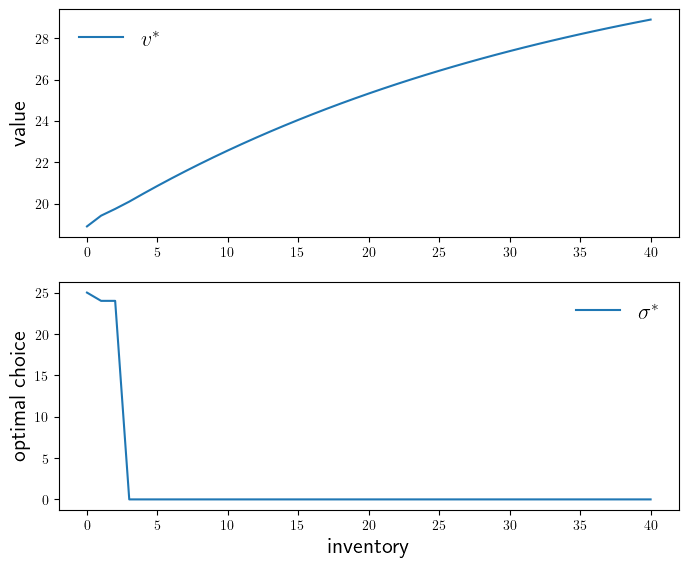

In [3]:
plot_vstar_and_opt_policy(savefig=true)

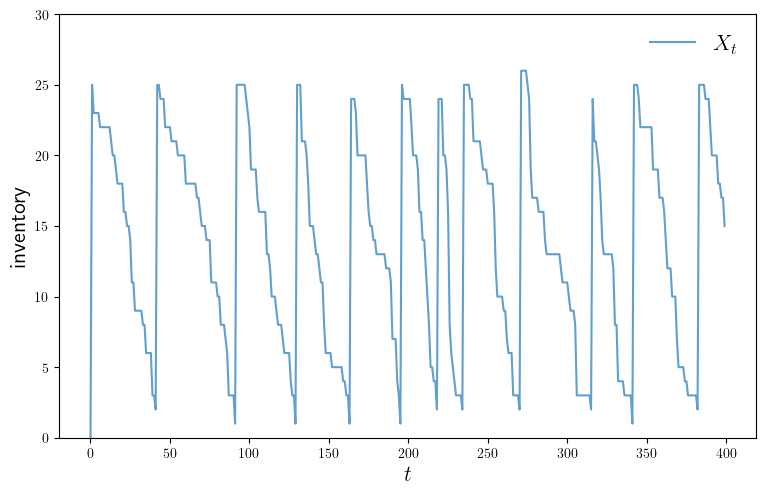

In [4]:
plot_ts(savefig=true)

#### finite_opt_saving_0.jl

In [5]:
using QuantEcon, LinearAlgebra, IterTools

function create_savings_model(; R=1.01, β=0.98, γ=2.5,  
                                w_min=0.01, w_max=20.0, w_size=200,
                                ρ=0.9, ν=0.1, y_size=5)
    w_grid = LinRange(w_min, w_max, w_size)  
    mc = tauchen(y_size, ρ, ν)
    y_grid, Q = exp.(mc.state_values), mc.p
    return (; β, R, γ, w_grid, y_grid, Q)
end

"B(w, y, w′, v) = u(R*w + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)."
function B(i, j, k, v, model)
    (; β, R, γ, w_grid, y_grid, Q) = model
    w, y, w′ = w_grid[i], y_grid[j], w_grid[k]
    u(c) = c^(1-γ) / (1-γ)
    c = w + y - (w′ / R)
    @views value = c > 0 ? u(c) + β * dot(v[k, :], Q[j, :]) : -Inf
    return value
end

"The Bellman operator."
function T(v, model)
    w_idx, y_idx = (eachindex(g) for g in (model.w_grid, model.y_grid))
    v_new = similar(v)
    for (i, j) in product(w_idx, y_idx)
        v_new[i, j] = maximum(B(i, j, k, v, model) for k in w_idx)
    end
    return v_new
end

"The policy operator."
function T_σ(v, σ, model)
    w_idx, y_idx = (eachindex(g) for g in (model.w_grid, model.y_grid))
    v_new = similar(v)
    for (i, j) in product(w_idx, y_idx)
        v_new[i, j] = B(i, j, σ[i, j], v, model) 
    end
    return v_new
end




T_σ

#### finite_opt_saving_1.jl

In [6]:
include("finite_opt_saving_0.jl")

"Compute a v-greedy policy."
function get_greedy(v, model)
    w_idx, y_idx = (eachindex(g) for g in (model.w_grid, model.y_grid))
    σ = Matrix{Int32}(undef, length(w_idx), length(y_idx))
    for (i, j) in product(w_idx, y_idx)
        _, σ[i, j] = findmax(B(i, j, k, v, model) for k in w_idx)
    end
    return σ
end

"Get the value v_σ of policy σ."
function get_value(σ, model)
    # Unpack and set up
    (; β, R, γ, w_grid, y_grid, Q) = model
    w_idx, y_idx = (eachindex(g) for g in (w_grid, y_grid))
    wn, yn = length(w_idx), length(y_idx)
    n = wn * yn
    u(c) = c^(1-γ) / (1-γ)
    # Build P_σ and r_σ as multi-index arrays
    P_σ = zeros(wn, yn, wn, yn)
    r_σ = zeros(wn, yn)
    for (i, j) in product(w_idx, y_idx)
            w, y, w′ = w_grid[i], y_grid[j], w_grid[σ[i, j]]
            r_σ[i, j] = u(w + y - w′/R)
        for (i′, j′) in product(w_idx, y_idx)
            if i′ == σ[i, j]
                P_σ[i, j, i′, j′] = Q[j, j′]
            end
        end
    end
    # Reshape for matrix algebra
    P_σ = reshape(P_σ, n, n)
    r_σ = reshape(r_σ, n)
    # Apply matrix operations --- solve for the value of σ 
    v_σ = (I - β * P_σ) \ r_σ
    # Return as multi-index array
    return reshape(v_σ, wn, yn)
end




get_value

#### finite_opt_saving_2.jl

In [7]:
include("s_approx.jl")
include("finite_opt_saving_1.jl")

"Value function iteration routine."
function value_iteration(model, tol=1e-5)
    vz = zeros(length(model.w_grid), length(model.y_grid))
    v_star = successive_approx(v -> T(v, model), vz, tolerance=tol)
    return get_greedy(v_star, model)
end

"Howard policy iteration routine."
function policy_iteration(model)
    wn, yn = length(model.w_grid), length(model.y_grid)
    σ = ones(Int32, wn, yn)
    i, error = 0, 1.0
    while error > 0
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = maximum(abs.(σ_new - σ))
        σ = σ_new
        i = i + 1
        println("Concluded loop $i with error $error.")
    end
    return σ
end

"Optimistic policy iteration routine."
function optimistic_policy_iteration(model; tolerance=1e-5, m=100)
    v = zeros(length(model.w_grid), length(model.y_grid))
    error = tolerance + 1
    while error > tolerance
        last_v = v
        σ = get_greedy(v, model)
        for i in 1:m
            v = T_σ(v, σ, model)
        end
        error = maximum(abs.(v - last_v))
    end
    return get_greedy(v, model)
end

# == Simulations and inequality measures == #

function simulate_wealth(m)

    model = create_savings_model()
    σ_star = optimistic_policy_iteration(model)
    (; β, R, γ, w_grid, y_grid, Q) = model

    # Simulate labor income (indices rather than grid values)
    mc = MarkovChain(Q)
    y_idx_series = simulate(mc, m)

    # Compute corresponding wealth time series
    w_idx_series = similar(y_idx_series)
    w_idx_series[1] = 1  # initial condition
    for t in 1:(m-1)
        i, j = w_idx_series[t], y_idx_series[t]
        w_idx_series[t+1] = σ_star[i, j]
    end
    w_series = w_grid[w_idx_series]

    return w_series
end

function lorenz(v)  # assumed sorted vector
    S = cumsum(v)  # cumulative sums: [v[1], v[1] + v[2], ... ]
    F = (1:length(v)) / length(v)
    L = S ./ S[end]
    return (; F, L) # returns named tuple
end

gini(v) = (2 * sum(i * y for (i,y) in enumerate(v))/sum(v)
           - (length(v) + 1))/length(v)



# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16

function plot_timing(; m_vals=collect(range(1, 600, step=10)),
                       savefig=false)
    model = create_savings_model(y_size=5)
    println("Running Howard policy iteration.")
    pi_time = @elapsed σ_pi = policy_iteration(model)
    println("PI completed in $pi_time seconds.")
    println("Running value function iteration.")
    vfi_time = @elapsed σ_vfi = value_iteration(model)
    println("VFI completed in $vfi_time seconds.")
    @assert σ_vfi == σ_pi "Warning: policies deviated."
    opi_times = []
    for m in m_vals
        println("Running optimistic policy iteration with m=$m.")
        opi_time = @elapsed σ_opi = optimistic_policy_iteration(model, m=m)
        @assert σ_opi == σ_pi "Warning: policies deviated."
        println("OPI with m=$m completed in $opi_time seconds.")
        push!(opi_times, opi_time)
    end
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(m_vals, fill(vfi_time, length(m_vals)), 
            lw=2, label="value function iteration")
    ax.plot(m_vals, fill(pi_time, length(m_vals)), 
            lw=2, label="Howard policy iteration")
    ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_xlabel(L"m", fontsize=fontsize)
    ax.set_ylabel("time", fontsize=fontsize)
    if savefig
        fig.savefig("figures/finite_opt_saving_2_1.pdf")
    end
    return (pi_time, vfi_time, opi_times)
end

function plot_policy(; method="pi")
    model = create_savings_model()
    (; β, R, γ, w_grid, y_grid, Q) = model
    if method == "vfi"
        σ_star =  value_iteration(model) 
    elseif method == "pi"
        σ_star = policy_iteration(model) 
    else
        σ_star = optimistic_policy_iteration(model)
    end
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_grid, w_grid, "k--", label=L"45")
    ax.plot(w_grid, w_grid[σ_star[:, 1]], label=L"\sigma^*(\cdot, y_1)")
    ax.plot(w_grid, w_grid[σ_star[:, end]], label=L"\sigma^*(\cdot, y_N)")
    ax.legend(fontsize=fontsize)
end


function plot_time_series(; m=2_000,
                           savefig=false, 
                           figname="figures/finite_opt_saving_ts.pdf")

    w_series = simulate_wealth(m)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_series, label=L"w_t")
    ax.set_xlabel("time", fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    if savefig
        fig.savefig(figname)
    end
end

function plot_histogram(; m=1_000_000,
                           savefig=false, 
                           figname="figures/finite_opt_saving_hist.pdf")

    w_series = simulate_wealth(m)
    g = round(gini(sort(w_series)), digits=2)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.hist(w_series, bins=40, density=true)
    ax.set_xlabel("wealth", fontsize=fontsize)
    ax.text(15, 0.4, "Gini = $g", fontsize=fontsize)

    if savefig
        fig.savefig(figname)
    end
end

function plot_lorenz(; m=1_000_000,
                           savefig=false, 
                           figname="figures/finite_opt_saving_lorenz.pdf")

    w_series = simulate_wealth(m)
    (; F, L) = lorenz(sort(w_series))

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(F, F, label="Lorenz curve, equality")
    ax.plot(F, L, label="Lorenz curve, wealth distribution")
    ax.legend()

    if savefig
        fig.savefig(figname)
    end
end

plot_lorenz (generic function with 1 method)

Running Howard policy iteration.


Concluded loop 1 with error 100.
Concluded loop 2 with error 80.
Concluded loop 3 with error 34.


Concluded loop 4 with error 20.
Concluded loop 5 with error 11.
Concluded loop 6 with error 5.


Concluded loop 7 with error 5.
Concluded loop 8 with error 3.
Concluded loop 9 with error 1.


Concluded loop 10 with error 1.
Concluded loop 11 with error 1.
Concluded loop 12 with error 1.


Concluded loop 13 with error 1.
Concluded loop 14 with error 1.
Concluded loop 15 with error 1.


Concluded loop 16 with error 1.
Concluded loop 17 with error 1.
Concluded loop 18 with error 1.


Concluded loop 19 with error 1.
Concluded loop 20 with error 1.
Concluded loop 21 with error 1.


Concluded loop 22 with error 1.
Concluded loop 23 with error 1.
Concluded loop 24 with error 0.
PI completed in 0.9338108 seconds.
Running value function iteration.


Completed iteration 25 with error 0.536460823305255.


Completed iteration 50 with error 0.2757145835707817.


Completed iteration 75 with error 0.15964723339326525.


Completed iteration 100 with error 0.0949415406202121.


Completed iteration 125 with error 0.056923225476566586.


Completed iteration 150 with error 0.034240232785961666.


Completed iteration 175 with error 0.02062794785982902.


Completed iteration 200 with error 0.012437154854268329.


Completed iteration 225 with error 0.007501837673245859.


Completed iteration 250 with error 0.004525955103851231.


Completed iteration 275 with error 0.0027308880659973056.


Completed iteration 300 with error 0.0016478769789003422.


Completed iteration 325 with error 0.0009943978415378751.


Completed iteration 350 with error 0.0006000718833334417.


Completed iteration 375 with error 0.000362118316374449.


Completed iteration 400 with error 0.0002185243788304092.


Completed iteration 425 with error 0.00013187135262171523.


Completed iteration 450 with error 7.957958084148231e-5.


Completed iteration 475 with error 4.802342870391385e-5.


Completed iteration 500 with error 2.898043207721912e-5.


Completed iteration 525 with error 1.7488664326492653e-5.


Completed iteration 550 with error 1.0553790730227774e-5.
Terminated successfully in 554 iterations.
VFI completed in 5.1103015 seconds.
Running optimistic policy iteration with m=1.


OPI with m=1 completed in 5.138445 seconds.
Running optimistic policy iteration with m=11.


OPI with m=11 completed in 0.654195 seconds.
Running optimistic policy iteration with m=21.


OPI with m=21 completed in 0.373935 seconds.
Running optimistic policy iteration with m=31.


OPI with m=31 completed in 0.315198 seconds.
Running optimistic policy iteration with m=41.


OPI with m=41 completed in 0.2719255 seconds.
Running optimistic policy iteration with m=51.


OPI with m=51 completed in 0.360379 seconds.
Running optimistic policy iteration with m=61.


OPI with m=61 completed in 0.3192831 seconds.
Running optimistic policy iteration with m=71.


OPI with m=71 completed in 0.3953153 seconds.
Running optimistic policy iteration with m=81.


OPI with m=81 completed in 0.3917538 seconds.
Running optimistic policy iteration with m=91.


OPI with m=91 completed in 0.4284871 seconds.
Running optimistic policy iteration with m=101.


OPI with m=101 completed in 0.4545201 seconds.
Running optimistic policy iteration with m=111.


OPI with m=111 completed in 0.4325462 seconds.
Running optimistic policy iteration with m=121.


OPI with m=121 completed in 0.4963537 seconds.
Running optimistic policy iteration with m=131.


OPI with m=131 completed in 0.4775249 seconds.
Running optimistic policy iteration with m=141.


OPI with m=141 completed in 0.5022333 seconds.
Running optimistic policy iteration with m=151.


OPI with m=151 completed in 0.512607 seconds.
Running optimistic policy iteration with m=161.


OPI with m=161 completed in 0.5446304 seconds.
Running optimistic policy iteration with m=171.


OPI with m=171 completed in 0.5438462 seconds.
Running optimistic policy iteration with m=181.


OPI with m=181 completed in 0.5669597 seconds.
Running optimistic policy iteration with m=191.


OPI with m=191 completed in 0.5793311 seconds.
Running optimistic policy iteration with m=201.


OPI with m=201 completed in 0.6637511 seconds.
Running optimistic policy iteration with m=211.


OPI with m=211 completed in 0.6112675 seconds.
Running optimistic policy iteration with m=221.


OPI with m=221 completed in 0.6279333 seconds.
Running optimistic policy iteration with m=231.


OPI with m=231 completed in 0.649071 seconds.
Running optimistic policy iteration with m=241.


OPI with m=241 completed in 0.6741571 seconds.
Running optimistic policy iteration with m=251.


OPI with m=251 completed in 0.7380948 seconds.
Running optimistic policy iteration with m=261.


OPI with m=261 completed in 0.7227621 seconds.
Running optimistic policy iteration with m=271.


OPI with m=271 completed in 0.7093872 seconds.
Running optimistic policy iteration with m=281.


OPI with m=281 completed in 0.7859981 seconds.
Running optimistic policy iteration with m=291.


OPI with m=291 completed in 0.7597163 seconds.
Running optimistic policy iteration with m=301.


OPI with m=301 completed in 0.782256 seconds.
Running optimistic policy iteration with m=311.


OPI with m=311 completed in 0.8189492 seconds.
Running optimistic policy iteration with m=321.


OPI with m=321 completed in 0.8294091 seconds.
Running optimistic policy iteration with m=331.


OPI with m=331 completed in 0.8493095 seconds.
Running optimistic policy iteration with m=341.


OPI with m=341 completed in 0.8761057 seconds.
Running optimistic policy iteration with m=351.


OPI with m=351 completed in 0.8718081 seconds.
Running optimistic policy iteration with m=361.


OPI with m=361 completed in 0.9004707 seconds.
Running optimistic policy iteration with m=371.


OPI with m=371 completed in 0.9871985 seconds.
Running optimistic policy iteration with m=381.


OPI with m=381 completed in 0.931313 seconds.
Running optimistic policy iteration with m=391.


OPI with m=391 completed in 0.9856586 seconds.
Running optimistic policy iteration with m=401.


OPI with m=401 completed in 0.9733874 seconds.
Running optimistic policy iteration with m=411.


OPI with m=411 completed in 1.0199085 seconds.
Running optimistic policy iteration with m=421.


OPI with m=421 completed in 0.9987277 seconds.
Running optimistic policy iteration with m=431.


OPI with m=431 completed in 1.036795 seconds.
Running optimistic policy iteration with m=441.


OPI with m=441 completed in 1.0619602 seconds.
Running optimistic policy iteration with m=451.


OPI with m=451 completed in 1.0659395 seconds.
Running optimistic policy iteration with m=461.


OPI with m=461 completed in 1.083608 seconds.
Running optimistic policy iteration with m=471.


OPI with m=471 completed in 1.1012165 seconds.
Running optimistic policy iteration with m=481.


OPI with m=481 completed in 1.1393144 seconds.
Running optimistic policy iteration with m=491.


OPI with m=491 completed in 1.1472677 seconds.
Running optimistic policy iteration with m=501.


OPI with m=501 completed in 1.1972453 seconds.
Running optimistic policy iteration with m=511.


OPI with m=511 completed in 1.1701216 seconds.
Running optimistic policy iteration with m=521.


OPI with m=521 completed in 1.2074719 seconds.
Running optimistic policy iteration with m=531.


OPI with m=531 completed in 1.2362591 seconds.
Running optimistic policy iteration with m=541.


OPI with m=541 completed in 1.2367478 seconds.
Running optimistic policy iteration with m=551.


OPI with m=551 completed in 1.2846699 seconds.
Running optimistic policy iteration with m=561.


OPI with m=561 completed in 1.268149 seconds.
Running optimistic policy iteration with m=571.


OPI with m=571 completed in 1.2869086 seconds.
Running optimistic policy iteration with m=581.


OPI with m=581 completed in 1.3154064 seconds.
Running optimistic policy iteration with m=591.


OPI with m=591 completed in 1.3460994 seconds.

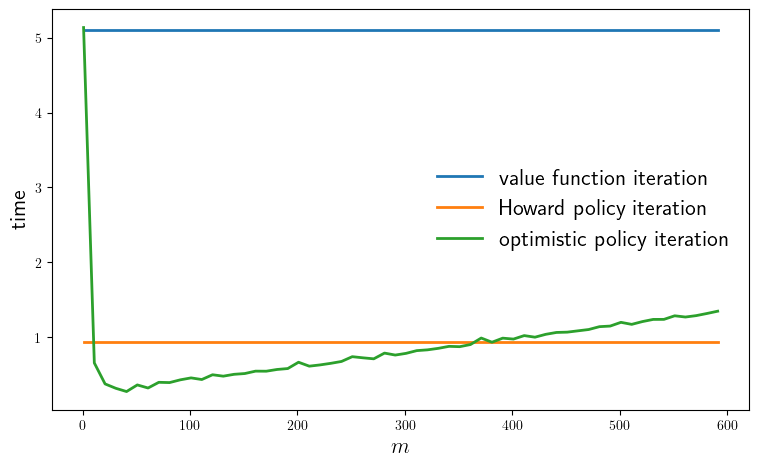

(0.9338108, 5.1103015, Any[5.138445, 0.654195, 0.373935, 0.315198, 0.2719255, 0.360379, 0.3192831, 0.3953153, 0.3917538, 0.4284871  …  1.1972453, 1.1701216, 1.2074719, 1.2362591, 1.2367478, 1.2846699, 1.268149, 1.2869086, 1.3154064, 1.3460994])

In [8]:
plot_timing(savefig=true)

Concluded loop 1 with error 100.
Concluded loop 2 with error 80.
Concluded loop 3 with error 34.


Concluded loop 4 with error 20.
Concluded loop 5 with error 11.
Concluded loop 6 with error 5.


Concluded loop 7 with error 5.
Concluded loop 8 with error 3.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.


Concluded loop 11 with error 1.
Concluded loop 12 with error 1.
Concluded loop 13 with error 1.
Concluded loop 14 with error 1.


Concluded loop 15 with error 1.
Concluded loop 16 with error 1.
Concluded loop 17 with error 1.
Concluded loop 18 with error 1.


Concluded loop 19 with error 1.
Concluded loop 20 with error 1.
Concluded loop 21 with error 1.
Concluded loop 22 with error 1.


Concluded loop 23 with error 1.
Concluded loop 24 with error 0.


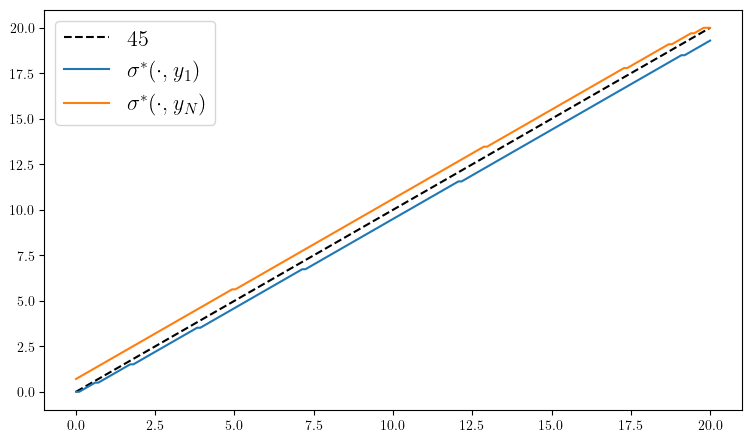

PyObject <matplotlib.legend.Legend object at 0x0000026EB99D0370>

In [9]:
plot_policy()

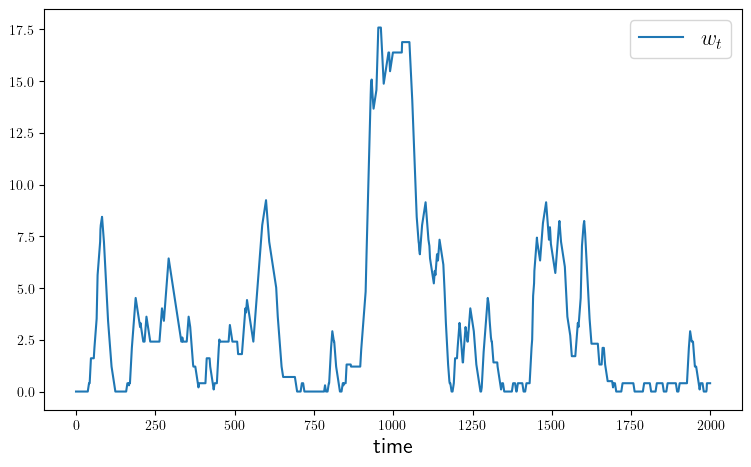

In [10]:
plot_time_series(savefig=true)

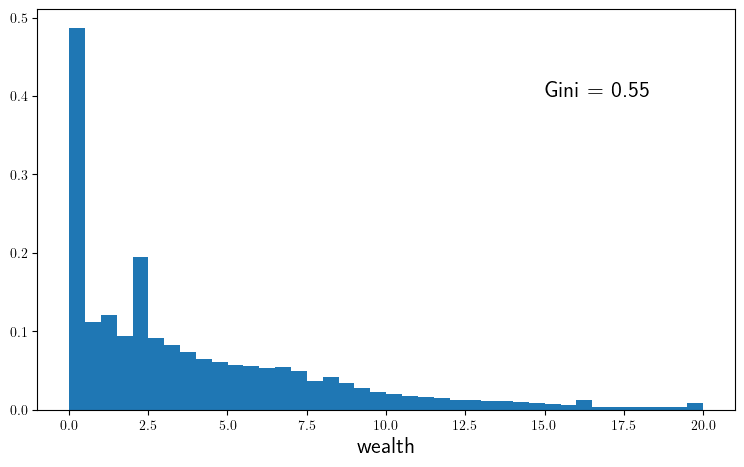

In [11]:
plot_histogram(savefig=true)

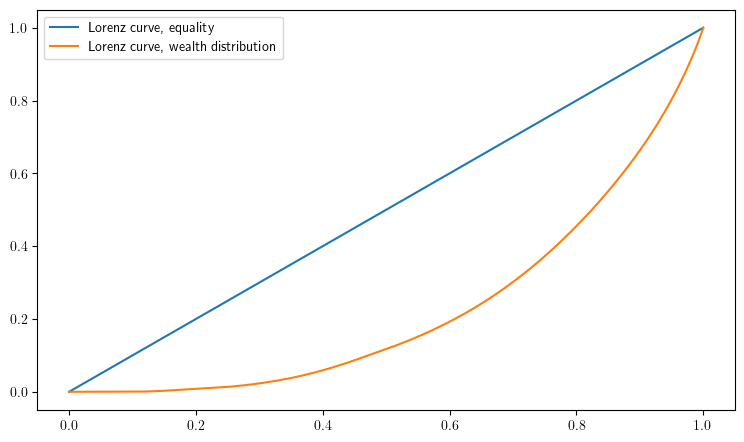

In [12]:
plot_lorenz(savefig=true)

#### finite_lq.jl

In [13]:
using QuantEcon, LinearAlgebra, IterTools
include("s_approx.jl")

function create_investment_model(; 
        r=0.04,                              # Interest rate
        a_0=10.0, a_1=1.0,                   # Demand parameters
        γ=25.0, c=1.0,                       # Adjustment and unit cost 
        y_min=0.0, y_max=20.0, y_size=100,   # Grid for output
        ρ=0.9, ν=1.0,                        # AR(1) parameters
        z_size=25)                           # Grid size for shock
    β = 1/(1+r) 
    y_grid = LinRange(y_min, y_max, y_size)  
    mc = tauchen(y_size, ρ, ν)
    z_grid, Q = mc.state_values, mc.p
    return (; β, a_0, a_1, γ, c, y_grid, z_grid, Q)
end

"""
The aggregator B is given by 

    B(y, z, y′) = r(y, z, y′) + β Σ_z′ v(y′, z′) Q(z, z′)."

where 

    r(y, z, y′) := (a_0 - a_1 * y + z - c) y - γ * (y′ - y)^2

"""
function B(i, j, k, v, model)
    (; β, a_0, a_1, γ, c, y_grid, z_grid, Q) = model
    y, z, y′ = y_grid[i], z_grid[j], y_grid[k]
    r = (a_0 - a_1 * y + z - c) * y - γ * (y′ - y)^2
    return @views r + β * dot(v[k, :], Q[j, :]) 
end

"The policy operator."
function T_σ(v, σ, model)
    y_idx, z_idx = (eachindex(g) for g in (model.y_grid, model.z_grid))
    v_new = similar(v)
    for (i, j) in product(y_idx, z_idx)
        v_new[i, j] = B(i, j, σ[i, j], v, model) 
    end
    return v_new
end

"The Bellman operator."
function T(v, model)
    y_idx, z_idx = (eachindex(g) for g in (model.y_grid, model.z_grid))
    v_new = similar(v)
    for (i, j) in product(y_idx, z_idx)
        v_new[i, j] = maximum(B(i, j, k, v, model) for k in y_idx)
    end
    return v_new
end

"Compute a v-greedy policy."
function get_greedy(v, model)
    y_idx, z_idx = (eachindex(g) for g in (model.y_grid, model.z_grid))
    σ = Matrix{Int32}(undef, length(y_idx), length(z_idx))
    for (i, j) in product(y_idx, z_idx)
        _, σ[i, j] = findmax(B(i, j, k, v, model) for k in y_idx)
    end
    return σ
end

"Value function iteration routine."
function value_iteration(model; tol=1e-5)
    vz = zeros(length(model.y_grid), length(model.z_grid))
    v_star = successive_approx(v -> T(v, model), vz, tolerance=tol)
    return get_greedy(v_star, model)
end



"Get the value v_σ of policy σ."
function get_value(σ, model)
    # Unpack and set up
    (; β, a_0, a_1, γ, c, y_grid, z_grid, Q) = model
    yn, zn = length(y_grid), length(z_grid)
    n = yn * zn
    # Function to extract (i, j) from m = i + (j-1)*yn"
    single_to_multi(m) = (m-1)%yn + 1, div(m-1, yn) + 1
    # Allocate and create single index versions of P_σ and r_σ
    P_σ = zeros(n, n)
    r_σ = zeros(n)
    for m in 1:n
        i, j = single_to_multi(m)
        y, z, y′ = y_grid[i], z_grid[j], y_grid[σ[i, j]]
        r_σ[m] = (a_0 - a_1 * y + z - c) * y - γ * (y′ - y)^2
        for m′ in 1:n
            i′, j′ = single_to_multi(m′)
            if i′ == σ[i, j]
                P_σ[m, m′] = Q[j, j′]
            end
        end
    end
    # Solve for the value of σ 
    v_σ = (I - β * P_σ) \ r_σ
    # Return as multi-index array
    return reshape(v_σ, yn, zn)
end


"Howard policy iteration routine."
function policy_iteration(model)
    yn, zn = length(model.y_grid), length(model.z_grid)
    σ = ones(Int32, yn, zn)
    i, error = 0, 1.0
    while error > 0
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = maximum(abs.(σ_new - σ))
        σ = σ_new
        i = i + 1
        println("Concluded loop $i with error $error.")
    end
    return σ
end

"Optimistic policy iteration routine."
function optimistic_policy_iteration(model; tol=1e-5, m=100)
    v = zeros(length(model.y_grid), length(model.z_grid))
    error = tol + 1
    while error > tol
        last_v = v
        σ = get_greedy(v, model)
        for i in 1:m
            v = T_σ(v, σ, model)
        end
        error = maximum(abs.(v - last_v))
    end
    return get_greedy(v, model)
end


# Plots

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=12

function plot_policy()
    model = create_investment_model()
    (; β, a_0, a_1, γ, c, y_grid, z_grid, Q) = model
    σ_star = optimistic_policy_iteration(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(y_grid, y_grid, "k--", label=L"45")
    ax.plot(y_grid, y_grid[σ_star[:, 1]], label=L"\sigma^*(\cdot, z_1)")
    ax.plot(y_grid, y_grid[σ_star[:, end]], label=L"\sigma^*(\cdot, z_N)")
    ax.legend(fontsize=fontsize)
end

function plot_sim(; savefig=false, figname="figures/finite_lq_1.pdf")
    ts_length = 200

    fig, axes = plt.subplots(4, 1, figsize=(9, 11.2))

    for (ax, γ) in zip(axes, (1, 10, 20, 30))
        model = create_investment_model(γ=γ)
        (; β, a_0, a_1, γ, c, y_grid, z_grid, Q) = model
        σ_star = optimistic_policy_iteration(model)
        mc = MarkovChain(Q, z_grid)

        z_sim_idx = simulate_indices(mc, ts_length)
        z_sim = z_grid[z_sim_idx]
        y_sim_idx = Vector{Int32}(undef, ts_length)
        y_1 = (a_0 - c + z_sim[1]) / (2 * a_1)
        y_sim_idx[1] = searchsortedfirst(y_grid, y_1)
        for t in 1:(ts_length-1)
            y_sim_idx[t+1] = σ_star[y_sim_idx[t], z_sim_idx[t]]
        end
        y_sim = y_grid[y_sim_idx]
        y_bar_sim = (a_0 .- c .+ z_sim) ./ (2 * a_1)

        ax.plot(1:ts_length, y_sim, label=L"Y_t")
        ax.plot(1:ts_length, y_bar_sim, label=L"\bar Y_t")
        ax.legend(fontsize=fontsize, frameon=false, loc="upper right")
        ax.set_ylabel("output", fontsize=fontsize)
        ax.set_ylim(1, 9)
        ax.set_title(L"\gamma = " * "$γ", fontsize=fontsize)
    end

    fig.tight_layout()
    if savefig
        fig.savefig(figname)
    end
end


function plot_timing(; m_vals=collect(range(1, 600, step=10)),
                   savefig=false,
                   figname="figures/finite_lq_time.pdf"
    )
    model = create_investment_model()
    #println("Running Howard policy iteration.")
    #pi_time = @elapsed σ_pi = policy_iteration(model)
    #println("PI completed in $pi_time seconds.")
    println("Running value function iteration.")
    vfi_time = @elapsed σ_vfi = value_iteration(model, tol=1e-5)
    println("VFI completed in $vfi_time seconds.")
    #@assert σ_vfi == σ_pi "Warning: policies deviated."
    opi_times = []
    for m in m_vals
        println("Running optimistic policy iteration with m=$m.")
        opi_time = @elapsed σ_opi = 
            optimistic_policy_iteration(model, m=m, tol=1e-5)
        println("OPI with m=$m completed in $opi_time seconds.")
        #@assert σ_opi == σ_pi "Warning: policies deviated."
        push!(opi_times, opi_time)
    end
    fig, ax = plt.subplots(figsize=(9, 5.2))
    #ax.plot(m_vals, fill(pi_time, length(m_vals)), 
    #        lw=2, label="Howard policy iteration")
    ax.plot(m_vals, fill(vfi_time, length(m_vals)), 
            lw=2, label="value function iteration")
    ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_xlabel(L"m", fontsize=fontsize)
    ax.set_ylabel("time", fontsize=fontsize)
    if savefig
        fig.savefig(figname)
    end
    return (vfi_time, opi_times)
    #return (pi_time, vfi_time, opi_times)
end

plot_timing (generic function with 1 method)

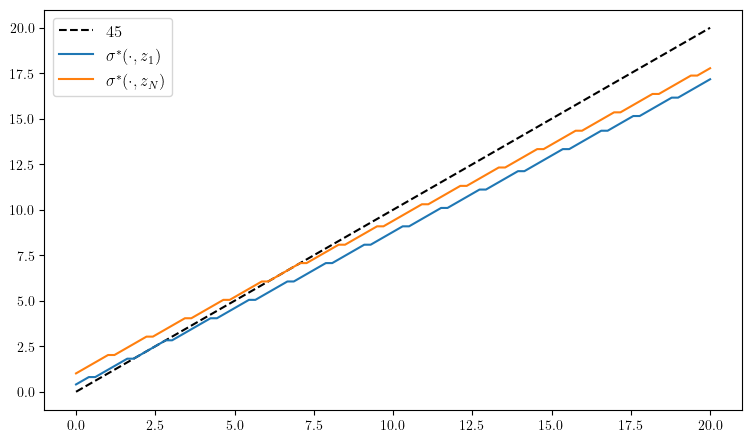

PyObject <matplotlib.legend.Legend object at 0x0000026ECE85C700>

In [14]:
plot_policy()

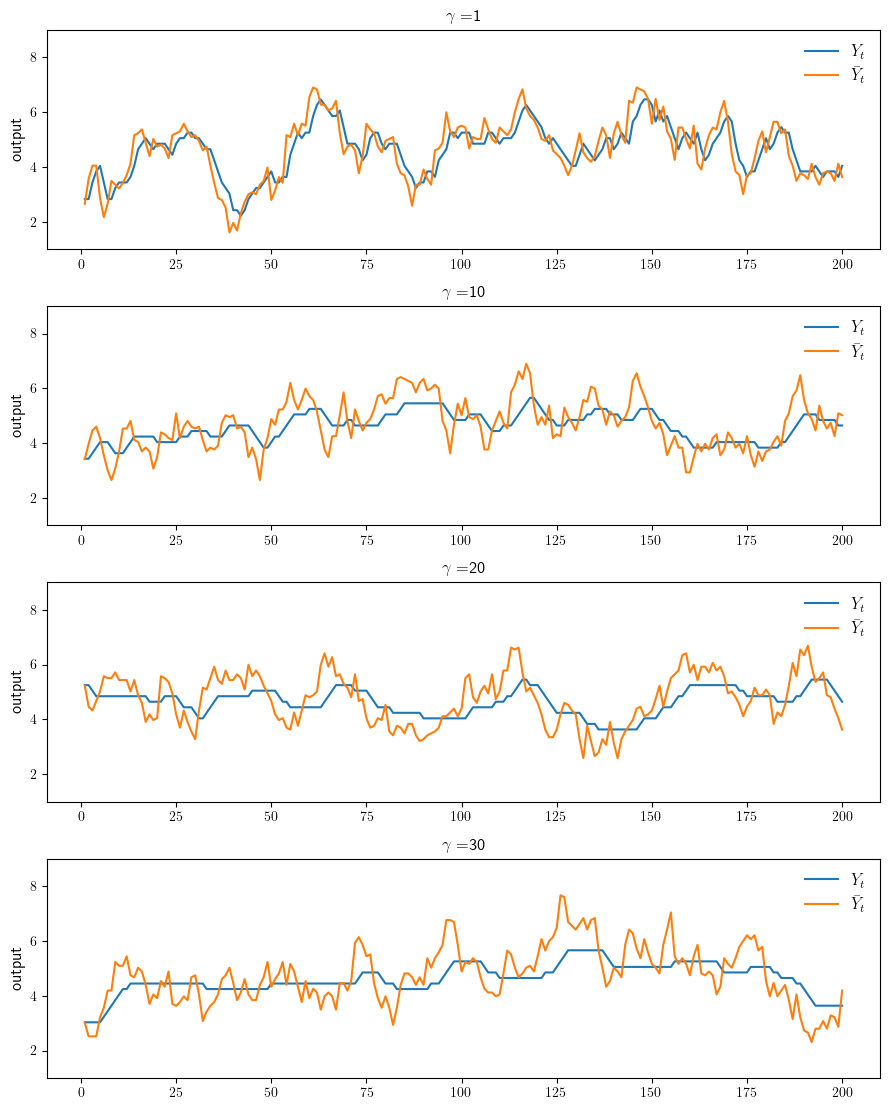

In [15]:
plot_sim(savefig=true)

Running value function iteration.


Completed iteration 25 with error 8.945294734337608.


Completed iteration 50 with error 3.0402862553364685.


Completed iteration 75 with error 1.1324022887380352.


Completed iteration 100 with error 0.42457216331251857.


Completed iteration 125 with error 0.15925863812981333.


Completed iteration 150 with error 0.05974044697506997.


Completed iteration 175 with error 0.02240964166935555.


Completed iteration 200 with error 0.008406233024402354.


Completed iteration 225 with error 0.003153319248781372.


Completed iteration 250 with error 0.0011828630332502144.


Completed iteration 275 with error 0.00044371179876634415.


Completed iteration 300 with error 0.000166443751368206.


Completed iteration 325 with error 6.243584812182235e-5.


Completed iteration 350 with error 2.3420735942636384e-5.


Terminated successfully in 373 iterations.
VFI completed in 28.2692755 seconds.
Running optimistic policy iteration with m=1.


OPI with m=1 completed in 31.8261874 seconds.
Running optimistic policy iteration with m=11.


OPI with m=11 completed in 3.500834 seconds.
Running optimistic policy iteration with m=21.


OPI with m=21 completed in 2.1387629 seconds.
Running optimistic policy iteration with m=31.


OPI with m=31 completed in 1.67683 seconds.
Running optimistic policy iteration with m=41.


OPI with m=41 completed in 1.4941611 seconds.
Running optimistic policy iteration with m=51.


OPI with m=51 completed in 1.3335186 seconds.
Running optimistic policy iteration with m=61.


OPI with m=61 completed in 1.3463767 seconds.
Running optimistic policy iteration with m=71.


OPI with m=71 completed in 1.273643 seconds.
Running optimistic policy iteration with m=81.


OPI with m=81 completed in 1.3694993 seconds.
Running optimistic policy iteration with m=91.


OPI with m=91 completed in 1.4073923 seconds.
Running optimistic policy iteration with m=101.


OPI with m=101 completed in 1.6298117 seconds.
Running optimistic policy iteration with m=111.


OPI with m=111 completed in 1.598744 seconds.
Running optimistic policy iteration with m=121.


OPI with m=121 completed in 1.6107097 seconds.
Running optimistic policy iteration with m=131.


OPI with m=131 completed in 1.7310308 seconds.
Running optimistic policy iteration with m=141.


OPI with m=141 completed in 1.7695995 seconds.
Running optimistic policy iteration with m=151.


OPI with m=151 completed in 2.0295818 seconds.
Running optimistic policy iteration with m=161.


OPI with m=161 completed in 2.1955621 seconds.
Running optimistic policy iteration with m=171.


OPI with m=171 completed in 2.2774677 seconds.
Running optimistic policy iteration with m=181.


OPI with m=181 completed in 2.2979581 seconds.
Running optimistic policy iteration with m=191.


OPI with m=191 completed in 2.1649434 seconds.
Running optimistic policy iteration with m=201.


OPI with m=201 completed in 2.164481 seconds.
Running optimistic policy iteration with m=211.


OPI with m=211 completed in 2.2490154 seconds.
Running optimistic policy iteration with m=221.


OPI with m=221 completed in 2.3496354 seconds.
Running optimistic policy iteration with m=231.


OPI with m=231 completed in 2.4630074 seconds.
Running optimistic policy iteration with m=241.


OPI with m=241 completed in 2.5070121 seconds.
Running optimistic policy iteration with m=251.


OPI with m=251 completed in 2.5671103 seconds.
Running optimistic policy iteration with m=261.


OPI with m=261 completed in 2.5986312 seconds.
Running optimistic policy iteration with m=271.


OPI with m=271 completed in 2.6766764 seconds.
Running optimistic policy iteration with m=281.


OPI with m=281 completed in 2.798076 seconds.
Running optimistic policy iteration with m=291.


OPI with m=291 completed in 2.8058795 seconds.
Running optimistic policy iteration with m=301.


OPI with m=301 completed in 2.8889114 seconds.
Running optimistic policy iteration with m=311.


OPI with m=311 completed in 2.9264634 seconds.
Running optimistic policy iteration with m=321.


OPI with m=321 completed in 2.9870698 seconds.
Running optimistic policy iteration with m=331.


OPI with m=331 completed in 3.0762279 seconds.
Running optimistic policy iteration with m=341.


OPI with m=341 completed in 3.1780416 seconds.
Running optimistic policy iteration with m=351.


OPI with m=351 completed in 3.3006793 seconds.
Running optimistic policy iteration with m=361.


OPI with m=361 completed in 3.2975963 seconds.
Running optimistic policy iteration with m=371.


OPI with m=371 completed in 3.3856441 seconds.
Running optimistic policy iteration with m=381.


OPI with m=381 completed in 3.4408702 seconds.
Running optimistic policy iteration with m=391.


OPI with m=391 completed in 3.48574 seconds.
Running optimistic policy iteration with m=401.


OPI with m=401 completed in 3.5772935 seconds.
Running optimistic policy iteration with m=411.


OPI with m=411 completed in 3.6592083 seconds.


Running optimistic policy iteration with m=421.
OPI with m=421 completed in 3.7025309 seconds.
Running optimistic policy iteration with m=431.


OPI with m=431 completed in 3.8058525 seconds.
Running optimistic policy iteration with m=441.


OPI with m=441 completed in 3.8476399 seconds.
Running optimistic policy iteration with m=451.


OPI with m=451 completed in 3.9322068 seconds.
Running optimistic policy iteration with m=461.


OPI with m=461 completed in 3.9595612 seconds.
Running optimistic policy iteration with m=471.


OPI with m=471 completed in 4.0756429 seconds.
Running optimistic policy iteration with m=481.


OPI with m=481 completed in 4.2000688 seconds.
Running optimistic policy iteration with m=491.


OPI with m=491 completed in 5.2796027 seconds.
Running optimistic policy iteration with m=501.


OPI with m=501 completed in 6.125796 seconds.
Running optimistic policy iteration with m=511.


OPI with m=511 completed in 5.9870601 seconds.
Running optimistic policy iteration with m=521.


OPI with m=521 completed in 4.6501108 seconds.
Running optimistic policy iteration with m=531.


OPI with m=531 completed in 5.2380956 seconds.
Running optimistic policy iteration with m=541.


OPI with m=541 completed in 5.4327141 seconds.
Running optimistic policy iteration with m=551.


OPI with m=551 completed in 5.1670988 seconds.
Running optimistic policy iteration with m=561.


OPI with m=561 completed in 4.8570427 seconds.
Running optimistic policy iteration with m=571.


OPI with m=571 completed in 4.8138963 seconds.
Running optimistic policy iteration with m=581.


OPI with m=581 completed in 4.9151512 seconds.
Running optimistic policy iteration with m=591.


OPI with m=591 completed in 5.0425255 seconds.

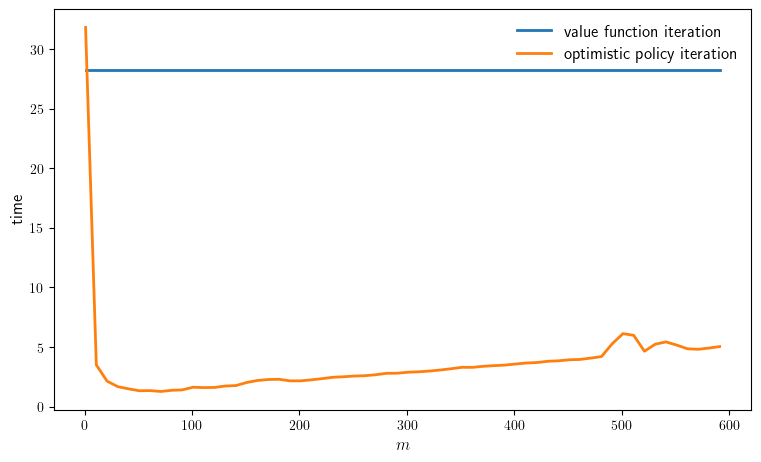

(28.2692755, Any[31.8261874, 3.500834, 2.1387629, 1.67683, 1.4941611, 1.3335186, 1.3463767, 1.273643, 1.3694993, 1.4073923  …  6.125796, 5.9870601, 4.6501108, 5.2380956, 5.4327141, 5.1670988, 4.8570427, 4.8138963, 4.9151512, 5.0425255])

In [16]:
plot_timing(savefig=true)

#### firm_hiring.jl

In [17]:
using QuantEcon, LinearAlgebra, IterTools

function create_hiring_model(; 
        r=0.04,                              # Interest rate
        κ=1.0,                               # Adjustment cost 
        α=0.4,                               # Production parameter
        p=1.0, w=1.0,                        # Price and wage
        l_min=0.0, l_max=30.0, l_size=100,   # Grid for labor
        ρ=0.9, ν=0.4, b=1.0,                 # AR(1) parameters
        z_size=100)                          # Grid size for shock
    β = 1/(1+r) 
    l_grid = LinRange(l_min, l_max, l_size)  
    mc = tauchen(z_size, ρ, ν, b, 6)
    z_grid, Q = mc.state_values, mc.p
    return (; β, κ, α, p, w, l_grid, z_grid, Q)
end

"""
The aggregator B is given by 

    B(l, z, l′) = r(l, z, l′) + β Σ_z′ v(l′, z′) Q(z, z′)."

where 

    r(l, z, l′) := p * z * f(l) - w * l - κ 1{l != l′}

"""
function B(i, j, k, v, model)
    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    l, z, l′ = l_grid[i], z_grid[j], l_grid[k]
    r = p * z * l^α - w * l - κ * (l != l′)
    return @views r + β * dot(v[k, :], Q[j, :]) 
end


"The policy operator."
function T_σ(v, σ, model)
    l_idx, z_idx = (eachindex(g) for g in (model.l_grid, model.z_grid))
    v_new = similar(v)
    for (i, j) in product(l_idx, z_idx)
        v_new[i, j] = B(i, j, σ[i, j], v, model) 
    end
    return v_new
end

"Compute a v-greedy policy."
function get_greedy(v, model)
    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    l_idx, z_idx = (eachindex(g) for g in (model.l_grid, model.z_grid))
    σ = Matrix{Int32}(undef, length(l_idx), length(z_idx))
    for (i, j) in product(l_idx, z_idx)
        _, σ[i, j] = findmax(B(i, j, k, v, model) for k in l_idx)
    end
    return σ
end

"Optimistic policy iteration routine."
function optimistic_policy_iteration(model; tolerance=1e-5, m=100)
    v = zeros(length(model.l_grid), length(model.z_grid))
    error = tolerance + 1
    while error > tolerance
        last_v = v
        σ = get_greedy(v, model)
        for i in 1:m
            v = T_σ(v, σ, model)
        end
        error = maximum(abs.(v - last_v))
    end
    return get_greedy(v, model)
end


# Plots

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=14

function plot_policy(; savefig=false, 
                    figname="figures/firm_hiring_pol.pdf")
    model = create_hiring_model()
    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    σ_star = optimistic_policy_iteration(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(l_grid, l_grid, "k--", label=L"45")
    ax.plot(l_grid, l_grid[σ_star[:, 1]], label=L"\sigma^*(\cdot, z_1)")
    ax.plot(l_grid, l_grid[σ_star[:, end]], label=L"\sigma^*(\cdot, z_N)")
    ax.legend(fontsize=fontsize)
end


function sim_dynamics(model, ts_length)

    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    σ_star = optimistic_policy_iteration(model)
    mc = MarkovChain(Q, z_grid)
    z_sim_idx = simulate_indices(mc, ts_length)
    z_sim = z_grid[z_sim_idx]
    l_sim_idx = Vector{Int32}(undef, ts_length)
    l_sim_idx[1] = 32
    for t in 1:(ts_length-1)
        l_sim_idx[t+1] = σ_star[l_sim_idx[t], z_sim_idx[t]]
    end
    l_sim = l_grid[l_sim_idx]

    y_sim = similar(l_sim)
    for (i, l) in enumerate(l_sim)
        y_sim[i] = p * z_sim[i] * l_sim[i]^α
    end

    t = ts_length - 1
    l_g, y_g, z_g = zeros(t), zeros(t), zeros(t)

    for i in 1:t
        l_g[i] = (l_sim[i+1] - l_sim[i]) / l_sim[i]
        y_g[i] = (y_sim[i+1] - y_sim[i]) / y_sim[i]
        z_g[i] = (z_sim[i+1] - z_sim[i]) / z_sim[i]
    end

    return l_sim, y_sim, z_sim, l_g, y_g, z_g

end



function plot_sim(; savefig=false, 
                    figname="figures/firm_hiring_ts.pdf",
                    ts_length = 250)

    model = create_hiring_model()
    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    l_sim, y_sim, z_sim, l_g, y_g, z_g = sim_dynamics(model, ts_length)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(1:ts_length, l_sim, label=L"\ell_t")
    ax.plot(1:ts_length, z_sim, alpha=0.6, label=L"Z_t")
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_ylabel("employment", fontsize=fontsize)
    ax.set_xlabel("time", fontsize=fontsize)

    if savefig
        fig.savefig(figname)
    end
end


function plot_growth(; savefig=false, 
                    figname="figures/firm_hiring_g.pdf",
                    ts_length = 10_000_000)

    model = create_hiring_model()
    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    l_sim, y_sim, z_sim, l_g, y_g, z_g = sim_dynamics(model, ts_length)

    fig, ax = plt.subplots()
    ax.hist(l_g, alpha=0.6, bins=100)
    ax.set_xlabel("growth", fontsize=fontsize)

    #fig, axes = plt.subplots(2, 1)
    #series = y_g, z_g
    #for (ax, g) in zip(axes, series)
    #    ax.hist(g, alpha=0.6, bins=100)
    #    ax.set_xlabel("growth", fontsize=fontsize)
    #end

    plt.tight_layout()
    if savefig
        fig.savefig(figname)
    end
end



plot_growth (generic function with 1 method)

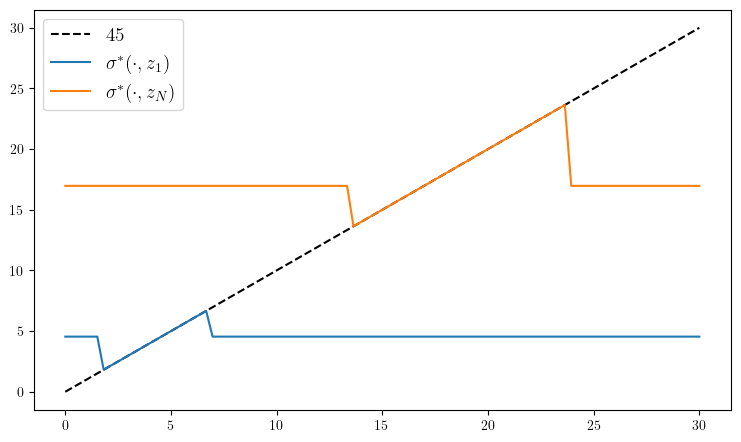

PyObject <matplotlib.legend.Legend object at 0x0000026EE642F4C0>

In [18]:
plot_policy()

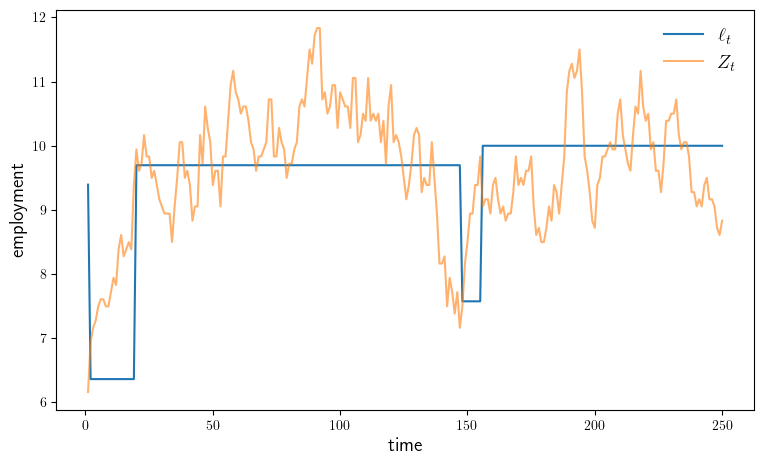

In [19]:
plot_sim(savefig=true)

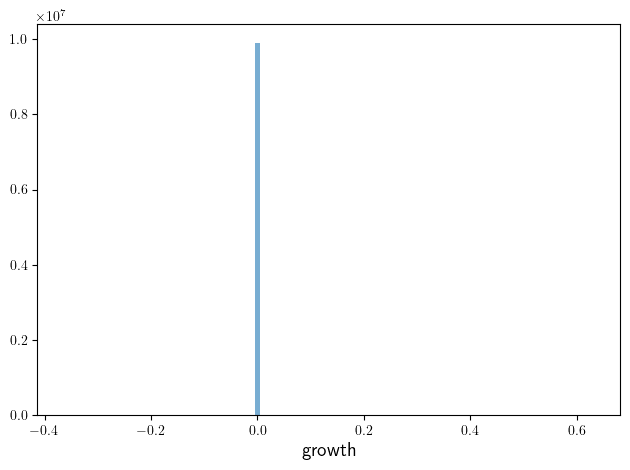

In [20]:
plot_growth(savefig=true)

#### modified_opt_savings.jl

In [21]:
using QuantEcon, LinearAlgebra, IterTools

function create_savings_model(; β=0.98, γ=2.5,  
                                w_min=0.01, w_max=20.0, w_size=100,
                                ρ=0.9, ν=0.1, y_size=20,
                                η_min=0.75, η_max=1.25, η_size=2)
    η_grid = LinRange(η_min, η_max, η_size)  
    ϕ = ones(η_size) * (1 / η_size)  # Uniform distributoin
    w_grid = LinRange(w_min, w_max, w_size)  
    mc = tauchen(y_size, ρ, ν)
    y_grid, Q = exp.(mc.state_values), mc.p
    return (; β, γ, η_grid, ϕ, w_grid, y_grid, Q)
end



## == Functions for regular OPI == ##

"""
B(w, y, η, w′) = u(w + y - w′/η)) + β Σ v(w′, y′, η′) Q(y, y′) ϕ(η′)
"""
function B(i, j, k, l, v, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    w, y, η, w′ = w_grid[i], y_grid[j], η_grid[k], w_grid[l]
    u(c) = c^(1-γ)/(1-γ)
    c = w + y - (w′/ η)
    exp_value = 0.0
    for m in eachindex(y_grid)
        for n in eachindex(η_grid)
            exp_value += v[l, m, n] * Q[j, m] * ϕ[n]
        end
    end
    return c > 0 ? u(c) + β * exp_value : -Inf
end

"The policy operator."
function T_σ(v, σ, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    grids = w_grid, y_grid, η_grid
    w_idx, y_idx, η_idx = (eachindex(g) for g in grids)
    v_new = similar(v)
    for (i, j, k) in product(w_idx, y_idx, η_idx)
        v_new[i, j, k] = B(i, j, k, σ[i, j, k], v, model) 
    end
    return v_new
end

"Compute a v-greedy policy."
function get_greedy(v, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    w_idx, y_idx, η_idx = (eachindex(g) for g in (w_grid, y_grid, η_grid))
    σ = Array{Int32}(undef, length(w_idx), length(y_idx), length(η_idx))
    for (i, j, k) in product(w_idx, y_idx, η_idx)
        _, σ[i, j, k] = findmax(B(i, j, k, l, v, model) for l in w_idx)
    end
    return σ
end


"Optimistic policy iteration routine."
function optimistic_policy_iteration(model; tolerance=1e-5, m=100)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    v = zeros(length(w_grid), length(y_grid), length(η_grid))
    error = tolerance + 1
    while error > tolerance
        last_v = v
        σ = get_greedy(v, model)
        for i in 1:m
            v = T_σ(v, σ, model)
        end
        error = maximum(abs.(v - last_v))
        println("OPI current error = $error")
    end
    return get_greedy(v, model)
end


## == Functions for modified OPI == ##

"D(w, y, η, w′, g) = u(w + y - w′/η) + β g(y, w′)."
@inline function D(i, j, k, l, g, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    w, y, η, w′ = w_grid[i], y_grid[j], η_grid[k], w_grid[l]
    u(c) = c^(1-γ)/(1-γ)
    c = w + y - (w′/η)
    return c > 0 ? u(c) + β * g[j, l] : -Inf
end


"Compute a g-greedy policy."
function get_g_greedy(g, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    w_idx, y_idx, η_idx = (eachindex(g) for g in (w_grid, y_grid, η_grid))
    σ = Array{Int32}(undef, length(w_idx), length(y_idx), length(η_idx))
    for (i, j, k) in product(w_idx, y_idx, η_idx)
        _, σ[i, j, k] = findmax(D(i, j, k, l, g, model) for l in w_idx)
    end
    return σ
end


"The modified policy operator."
function R_σ(g, σ, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    w_idx, y_idx, η_idx = (eachindex(g) for g in (w_grid, y_grid, η_grid))
    g_new = similar(g)
    for (j, i′) in product(y_idx, w_idx)  # j indexes y, i′ indexes w′ 
        out = 0.0
        for j′ in y_idx                   # j′ indexes y′
            for k′ in η_idx               # k′ indexes η′
                out += D(i′, j′, k′, σ[i′, j′, k′], g, model) * 
                        Q[j, j′] * ϕ[k′]
            end
        end
        g_new[j, i′] = out
    end
    return g_new
end


"Modified optimistic policy iteration routine."
function mod_opi(model; tolerance=1e-5, m=100)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    g = zeros(length(y_grid), length(w_grid))
    error = tolerance + 1
    while error > tolerance
        last_g = g
        σ = get_g_greedy(g, model)
        for i in 1:m
            g = R_σ(g, σ, model)
        end
        error = maximum(abs.(g - last_g))
        println("OPI current error = $error")
    end
    return get_g_greedy(g, model)
end


# == Simulations and inequality measures == #

function simulate_wealth(m)

    model = create_savings_model()
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    σ_star = mod_opi(model)

    # Simulate labor income
    mc = MarkovChain(Q)
    y_idx_series = simulate(mc, m)

    # IID Markov chain with uniform draws
    l = length(η_grid)
    mc = MarkovChain(ones(l, l) * (1/l))
    η_idx_series = simulate(mc, m)

    w_idx_series = similar(y_idx_series)
    w_idx_series[1] = 1
    for t in 1:(m-1)
        i, j, k = w_idx_series[t], y_idx_series[t], η_idx_series[t]
        w_idx_series[t+1] = σ_star[i, j, k]
    end

    w_series = w_grid[w_idx_series]
    return w_series
end


function lorenz(v)  # assumed sorted vector
    S = cumsum(v)  # cumulative sums: [v[1], v[1] + v[2], ... ]
    F = (1:length(v)) / length(v)
    L = S ./ S[end]
    return (; F, L) # returns named tuple
end


gini(v) = (2 * sum(i * y for (i,y) in enumerate(v))/sum(v)
           - (length(v) + 1))/length(v)


# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16



function plot_contours(; savefig=false, 
                         figname="figures/modified_opt_savings_1.pdf")

    model = create_savings_model()
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    σ_star = optimistic_policy_iteration(model)

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    y_idx, η_idx = eachindex(y_grid), eachindex(η_grid)
    H = zeros(length(y_grid), length(η_grid))

    w_indices = (1, length(w_grid))
    titles = "low wealth", "high wealth"
    for (ax, w_idx, title) in zip(axes, w_indices, titles)

        for (i_y, i_ϵ) in product(y_idx, η_idx)
            w, y, η = w_grid[w_idx], y_grid[i_y], η_grid[i_ϵ]
            H[i_y, i_ϵ] = w_grid[σ_star[w_idx, i_y, i_ϵ]] / (w+y)
        end

        cs1 = ax.contourf(y_grid, η_grid, transpose(H), alpha=0.5)
        plt.colorbar(cs1, ax=ax) #, format="%.6f")

        ax.set_title(title, fontsize=fontsize)
        ax.set_xlabel(L"y", fontsize=fontsize)
        ax.set_ylabel(L"\varepsilon", fontsize=fontsize)
    end

    plt.tight_layout()
    if savefig
        fig.savefig(figname)
    end
end


function plot_policies(; savefig=false, 
                         figname="figures/modified_opt_savings_2.pdf")

    model = create_savings_model()
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    σ_star = mod_opi(model)
    y_bar = floor(Int, length(y_grid) / 2)  # Index of mid-point of y_grid

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_grid, w_grid, "k--", label=L"45")

    for (i, η) in enumerate(η_grid)
        label = L"\sigma^*" * " at " * L"\eta = " * "$η"
        ax.plot(w_grid, w_grid[σ_star[:, y_bar, i]], label=label)
    end
    ax.legend(fontsize=fontsize)

    plt.tight_layout()
    if savefig
        fig.savefig(figname)
    end
end


function plot_time_series(; m=2_000,
                           savefig=false, 
                           figname="figures/modified_opt_savings_ts.pdf")

    w_series = simulate_wealth(m)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_series, label=L"w_t")
    ax.legend(fontsize=fontsize)
    ax.set_xlabel("time", fontsize=fontsize)
    if savefig
        fig.savefig(figname)
    end

end

function plot_histogram(; m=1_000_000,
                           savefig=false, 
                           figname="figures/modified_opt_savings_hist.pdf")

    w_series = simulate_wealth(m)
    g = round(gini(sort(w_series)), digits=2)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.hist(w_series, bins=40, density=true)
    ax.set_xlabel("wealth", fontsize=fontsize)
    ax.text(15, 0.7, "Gini = $g", fontsize=fontsize)
    if savefig
        fig.savefig(figname)
    end

end


function plot_lorenz(; m=1_000_000,
                           savefig=false, 
                           figname="figures/modified_opt_savings_lorenz.pdf")

    w_series = simulate_wealth(m)
    (; F, L) = lorenz(sort(w_series))

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(F, F, label="Lorenz curve, equality")
    ax.plot(F, L, label="Lorenz curve, wealth distribution")
    ax.legend()
    if savefig
        fig.savefig(figname)
    end

end

plot_lorenz (generic function with 1 method)

OPI current error = 38.399920491529734


OPI current error = 4.066951180848044
OPI current error = 4.6380954261438845
OPI current error = 1.3260813588221083


OPI current error = 0.38722029225052523
OPI current error = 0.09428546775951219


OPI current error = 0.02026455329022525


OPI current error = 0.002633073607984926
OPI current error = 0.00013614255682270482


OPI current error = 7.911990667963664e-6


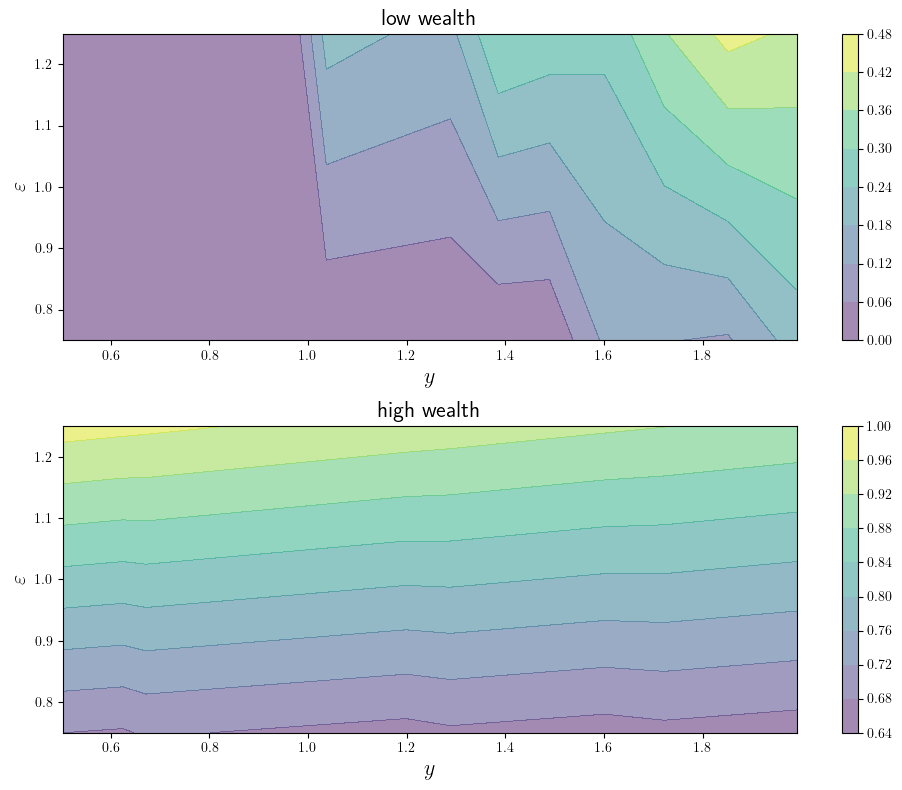

In [22]:
plot_contours(savefig=true)

OPI current error = 37.35040200118496


OPI current error = 4.066625094726078


OPI current error = 3.892585870289693


OPI current error = 1.1681955052615045


OPI current error = 0.3343174765677297


OPI current error = 0.06611271436991473


OPI current error = 0.010680300539267051


OPI current error = 0.0009714030350238545


OPI current error = 7.058042499252792e-5


OPI current error = 7.91199024874345e-6


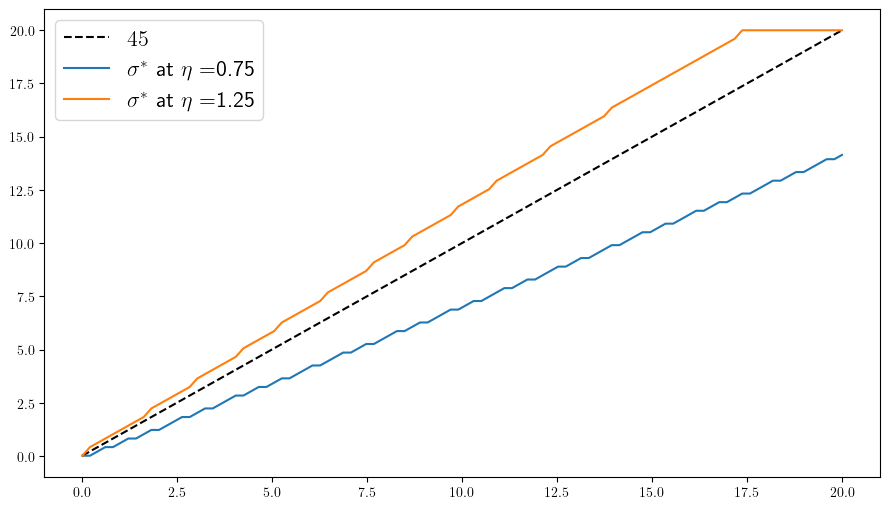

In [23]:
plot_policies(savefig=true)

OPI current error = 37.35040200118496


OPI current error = 4.066625094726078


OPI current error = 3.892585870289693


OPI current error = 1.1681955052615045


OPI current error = 0.3343174765677297


OPI current error = 0.06611271436991473


OPI current error = 0.010680300539267051


OPI current error = 0.0009714030350238545


OPI current error = 7.058042499252792e-5


OPI current error = 7.91199024874345e-6


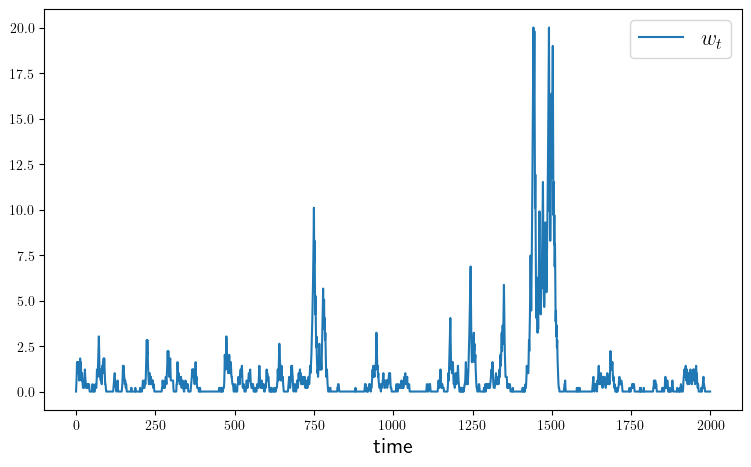

In [24]:
plot_time_series(savefig=true)

OPI current error = 37.35040200118496


OPI current error = 4.066625094726078


OPI current error = 3.892585870289693


OPI current error = 1.1681955052615045


OPI current error = 0.3343174765677297


OPI current error = 0.06611271436991473


OPI current error = 0.010680300539267051


OPI current error = 0.0009714030350238545


OPI current error = 7.058042499252792e-5


OPI current error = 7.91199024874345e-6

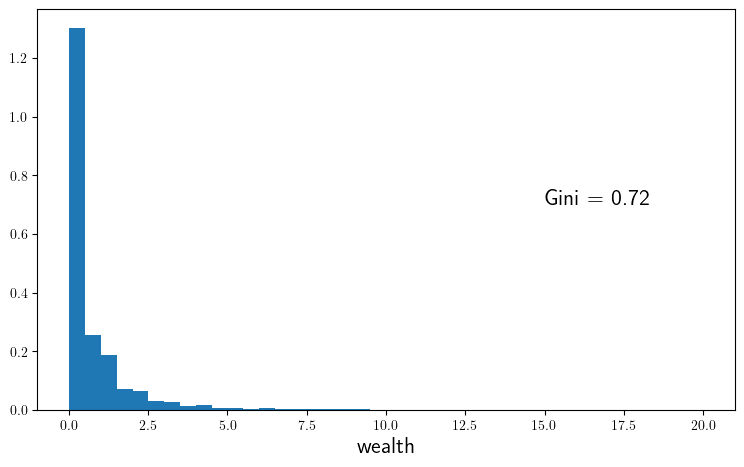

In [25]:
plot_histogram(savefig=true)

OPI current error = 37.35040200118496


OPI current error = 4.066625094726078


OPI current error = 3.892585870289693


OPI current error = 1.1681955052615045


OPI current error = 0.3343174765677297


OPI current error = 0.06611271436991473


OPI current error = 0.010680300539267051


OPI current error = 0.0009714030350238545


OPI current error = 7.058042499252792e-5


OPI current error = 7.91199024874345e-6

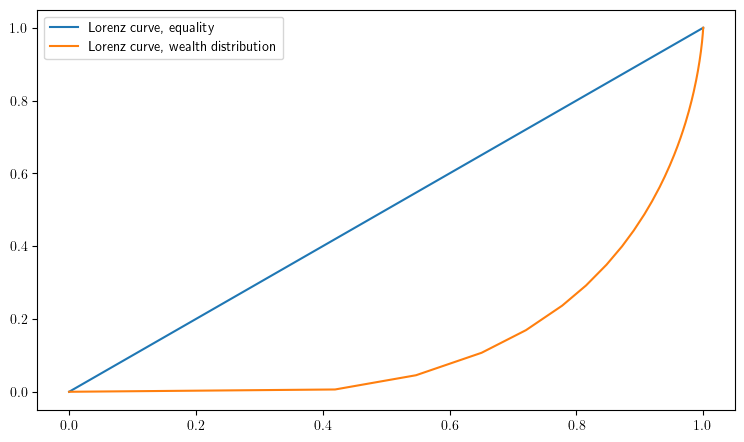

In [26]:
plot_lorenz(savefig=true)